# DMD, eDMD, HankelDMD (Analysis not yet ready)

### importing libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Setting parameters

In [2]:
##### %%writefile code_execution_constants.py
# ^ is storing global variables to file

DMD_type = 'eDMD'  #DMD or eDMD or HankelDMD
step = 'N_step'  #Calculates a the system dynamics matrix for one step but can be one_step or N_step prediction
basis_type = 'Monomials'  #Monomials, Hermite, Legendre. ###Note, Legendre not used as indicator functions oe=wing to scalability
basis_order = 7

system_name = 'Duffing' #Glycoscillator 0.3 x [10, 30] L7 or Repressilator 0.2 x [50, 150] H3 or Duffing 1000 x 0.5 x [0:0.25:2.5] M10 vs Test 10
num_train = 1
num_test = 1  #num of test states in Simulation_Init_conditions.py. More test or training can be added there
dt = 0.015 * 1   # time interval for simulation


data_trained = 0.99 # * 9  #ratio of post-transient data shown FROM EACH TRAJECTORY - %test PE between 0.13 to 0.17
transient_skip = 0 # Time stamp upto which data is not considered for training. Minimum dt for indexing purposes
T = 1.5 * 1 #simulation end time

#Post-transient results: Monomials2 and Hermite3 for Rerpessilator, Hermite2 for Glycoscillator
# 0.17 on T = 100 for Repressilator


### Derived time series

In [3]:
#Added 1 to adjust length of time frames so that Hankel matrix can be constructed

t_seen = data_trained*(T - transient_skip) + transient_skip  #calculating training time based on ratio of data shown
transient_span = np.linspace(0,transient_skip,np.int(1+transient_skip//dt))  #transient time
test_span = np.linspace(transient_skip,T,np.int(1+(T-transient_skip)//dt))  #test time
seen_last = (np.abs(test_span - t_seen)).argmin();
seen_span = test_span[:seen_last+1]  #training time
unseen_span = test_span[seen_last:]  #Cross Validation time

l_transient = len(transient_span)   #transient data length
l_seen = len(seen_span)    #training data length
l_unseen = len(unseen_span)    #cross validation data length
l_test = len(test_span)  #test data lenght

# print(l_transient, l_seen, l_unseen, l_test)

#ignore the below message, if error is thrown, check that the seen and unseen lengths give 1 when taken mod 10
# print(transient_span, seen_span, unseen_span, test_span)


### ICs

In [4]:
import Init_conditions  #module with initial conditions for system
init = getattr(Init_conditions, system_name)  #getting function for specific system
IC = init(num_train, num_test)   #ICs for the model

In [5]:
#%%writefile -a code_execution_constants.py
# ^ is appending num_states to file

num_states, num_init = IC.shape #number of states, initial conditions
num_train = num_init - num_test # 1 test trajectory
# print(num_states, num_train, num_test)


### Time Series Simulation 

In [6]:
import System_models #module with system models
model_to_simulate = getattr(System_models, system_name)  #getting function for specific model

training_data = np.empty([num_states,l_seen,num_train])   #initializing empty arrays for training,
cv_data = np.empty([num_states,l_unseen,num_train])    #cross validation and
test_data = np.empty([num_states,l_test,num_test])    #test data

for i in np.arange(0,num_train):   #looping over number of ICs
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    training_data[:,:,i] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],seen_span))   #training data
    cv_data[:,:,i] = np.transpose(odeint(model_to_simulate,training_data[:,l_seen-1,i],unseen_span))  #cross validation data

for i in np.arange(num_train,num_init):
    transient_data = np.transpose(odeint(model_to_simulate,IC[:,i],transient_span))   #transient part to be removed
    test_data[:,:,i-num_train] = np.transpose(odeint(model_to_simulate,transient_data[:,l_transient-1],test_span))   #test_data

# print(training_data.shape, cv_data.shape, test_data.shape)


### Simulation Plots for visualization 

In [7]:
def visualize_time_series(num_IC,t_span,data): #function to plot difference in training, cross validation and test data
    for i in np.arange(num_IC):
        plt.plot(t_span,np.transpose(data[:,:,i]))
    plt.xlabel('time')
    plt.ylabel('Concentratrions')
    f = plt.gcf()
    return f

def visualize_state_space(num_IC, t_span, data):
    for l in np.arange(num_IC):
        plt.plot(data[0,:,l],data[1,:,l])
    f = plt.gcf()
    return f

def compare_time_series(num_IC,t_span,sim_data,est_data): #function to plot difference in training, cross validation and test data
    for i in np.arange(num_IC):
        plt.plot(t_span[1:],np.transpose(sim_data[:,1:,i]))
        plt.plot(t_span[1:],np.transpose(est_data[:,:,i]),'--')
    plt.xlabel('time')
    plt.ylabel('Concentratrions')
    f = plt.gcf()
    return f

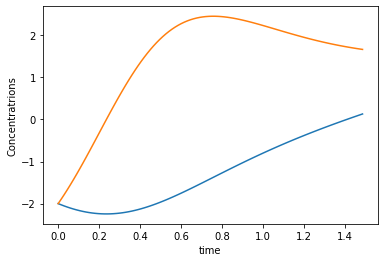

In [8]:
time_training = visualize_time_series(num_train,seen_span,training_data)
time_training.savefig("time_training.pdf", bbox_inches='tight')

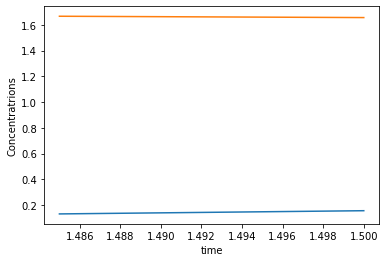

In [9]:
time_cv = visualize_time_series(num_train,unseen_span,cv_data)
time_cv.savefig("time_cv.pdf", bbox_inches = 'tight')

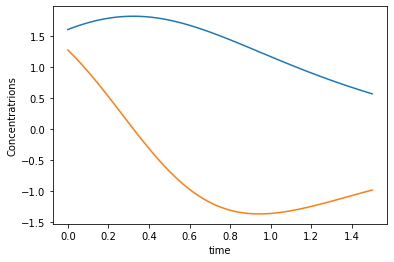

In [10]:
time_test = visualize_time_series(num_test,test_span,test_data)
time_test.savefig("time_test.pdf", bbox_inches = 'tight')

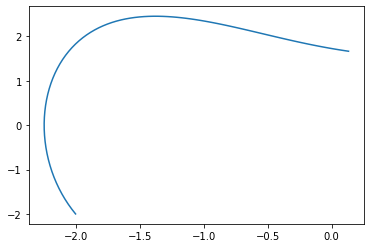

In [11]:
state_training = visualize_state_space(num_train, seen_span, training_data)
state_training.savefig("state_training.pdf", bbox_inches = 'tight')


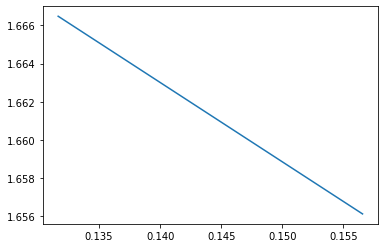

In [12]:
state_cv = visualize_state_space(num_train, unseen_span, cv_data)
state_cv.savefig("state_cv.pdf", bbox_inches = 'tight')


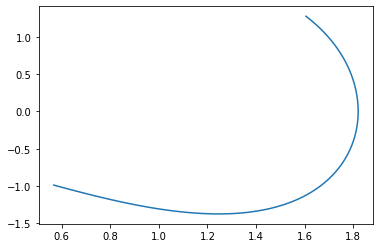

In [13]:
state_test = visualize_state_space(num_test, test_span, test_data)
state_test.savefig("state_test.pdf", bbox_inches = 'tight')

### Koopman operator matrix representation

In [14]:
if DMD_type == 'DMD':
    basis_order = 1

import DMD_algorithms #importing DMD algorithms module
#print(training_data.shape)
DMD = getattr(DMD_algorithms, DMD_type) #calling specific DMD algorithm
G, A, K, C = DMD(training_data,basis_type,basis_order) # K approximation using one step estimation
print('Size of K = ', K.shape)
print('Size of C = ', C.shape)

print('Rank of G = ', np.linalg.matrix_rank(G))
print('Condition number of G = ', np.linalg.cond(G))
print('Rank of A = ', np.linalg.matrix_rank(A))
print('Condition number of A = ', np.linalg.cond(A))
print('Rank of K = ', np.linalg.matrix_rank(K))
print('Condition number of K = ', np.linalg.cond(K))
print('Rank of C = ', np.linalg.matrix_rank(C))
print('Condition number of C = ', np.linalg.cond(C))


Size of K =  (36, 36)
Size of C =  (36, 2)
Rank of G =  17
Condition number of G =  4.532257021951035e+19
Rank of A =  17
Condition number of A =  1.705999055979681e+19
Rank of K =  36
Condition number of K =  247615144.6212793
Rank of C =  2
Condition number of C =  1.1184958204267113


### Predictions and Error (Not ready for HankelDMD)

In [15]:
import Prediction  #importing one step and N step predictor modules
prediction = getattr(Prediction, step)  #calling specific predictor

training_data_est, training_error = prediction(training_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of minimization using inversion
cv_data_est, cv_error = prediction(cv_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of error on future of trajectories used to train
test_data_est, test_error = prediction(test_data, np.transpose(K), np.transpose(C), basis_type, basis_order) #indicator of prediction on unseen initial conditions
#Errors only in state
# *_data_est is full observables
print('Error on used data = ', "{0:0f}%".format(training_error *100))
print('Error on unused from same trajectories = ', "{0:0f}%".format(cv_error *100))
print('Error on different trajectories = ', "{0:0f}%".format(test_error *100))
# print(lifted_training_data_est.shape)
# print(cv_data_est.shape)
# print(cv_data.shape)
# print(test_data_est.shape)
# print(test_data.shape)

print('Trained trajectories = ', num_train)
print('Training horizon = ', l_seen-1)
print('Total training data = ', num_train*(l_seen - 1))

print('CV trajectories = ', num_train)
print('CV horizon = ', l_unseen - 1)
print('Total CV data = ', num_train*(l_unseen-1))

print('Test trajectories = ', num_test)
print('Test horizon = ', l_test - 1)
print('Total test data = ', num_test*(l_test - 1))


Error on used data =  55.799988%
Error on unused from same trajectories =  0.054009%
Error on different trajectories =  9852.069563%
Trained trajectories =  1
Training horizon =  99
Total training data =  99
CV trajectories =  1
CV horizon =  1
Total CV data =  1
Test trajectories =  1
Test horizon =  100
Total test data =  100


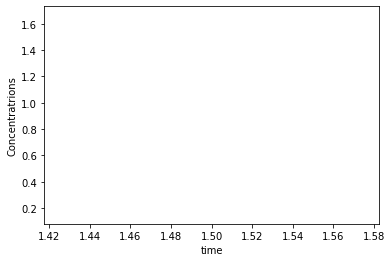

In [16]:
compare_cv = compare_time_series(num_train,unseen_span,cv_data,cv_data_est)
compare_cv.savefig("compare_cv.pdf", bbox_inches = 'tight')

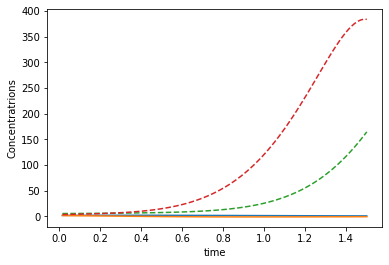

In [17]:
compare_test = compare_time_series(num_test,test_span,test_data,test_data_est)
compare_test.savefig("compare_test.pdf", bbox_inches = 'tight')